## get the activity bump by rearranging the firing field of all the detected neurons

In [32]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tf

import sys
sys.path.append("..")
from utils_analysis import plot_trajectory, getTuningMap, make_movie

### get the trajectory

In [33]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_04082023"
filenamelist = ["00019", "00020", "00022", "00027", "00028", "00029", "00030", "00031", "00032", "00033", "00034", "00035", "00038"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
else:
    allX, allZ, allTime, fig = plot_trajectory(datafolder, filenamelist)

### get suite2p outputs, e.g., stats, isc

In [34]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_04082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)

### Get the firing field of each detected cell

In [35]:
#chnage allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#select neurons with iscell firstcolumn ==1
spks_cells = spks[iscell[:,0]==1]
#also get the index
cell_idx = np.where(iscell[:,0]==1)[0]

#for each neuron, calculate the tuning map
#init a dictionary to store the coordinates of the maximum firing rate of each cell
maxFRCoord = {}
for i in range(len(spks_cells)):
    print('processing cell %d' % cell_idx[i])
    map = getTuningMap(spks_cells[i], Traj_x, Traj_z, timestamps, VRsize=(1,1), 
                    binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, 
                    visit_thres=0.1, cell_id=cell_idx[i], datafolder=datafolder)
    
    #get the x and y coordinates of the maximum value in the map, without considering nan values in map
    maxidx = np.where(map == np.nanmax(map))
    #normalize the coordinates to [0,1]
    maxidx_y = (maxidx[0][0]+0.5)/map.shape[0]
    maxidx_x = (maxidx[1][0]+0.5)/map.shape[1]
    
    #save the coordinates to the dictionary
    maxFRCoord[cell_idx[i]] = (maxidx_y, maxidx_x)

    

processing cell 0
processing cell 2
processing cell 3
processing cell 4
processing cell 5
processing cell 6
processing cell 7
processing cell 9
processing cell 12
processing cell 13
processing cell 14
processing cell 15
processing cell 16
processing cell 17
processing cell 19
processing cell 20
processing cell 21
processing cell 22
processing cell 23
processing cell 26
processing cell 27
processing cell 30
processing cell 33
processing cell 34
processing cell 36
processing cell 37
processing cell 41
processing cell 43
processing cell 46
processing cell 47
processing cell 48
processing cell 49
processing cell 50
processing cell 51
processing cell 56
processing cell 58
processing cell 59
processing cell 61
processing cell 65
processing cell 67
processing cell 68
processing cell 69
processing cell 70
processing cell 73
processing cell 75
processing cell 78
processing cell 79
processing cell 83
processing cell 84
processing cell 85
processing cell 86
processing cell 87
processing cell 88
p

### Rearranage all the detected cells with their firing field

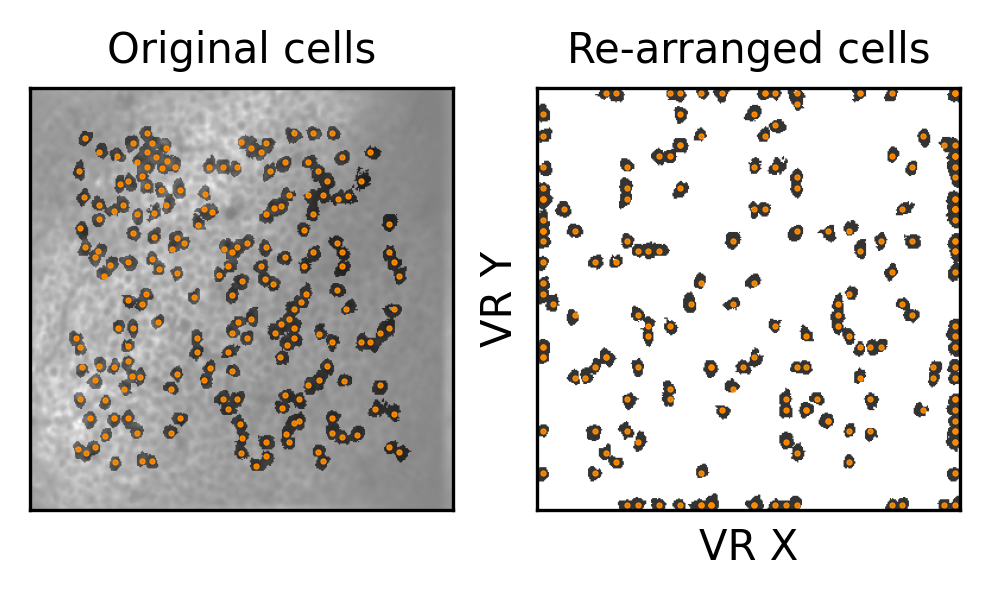

In [44]:
#genetate a mask with the same size as the tiff images

mask_img = np.ones((ops['Ly'], ops['Lx']))

#init center of detected cells
centerx = []
centery = []
#plot each neuron mask on the black image
for i in range(len(stats)):
    if iscell[i][0] == 1:
    #if iscell[i][0] == 1 or iscell[i][0] == 0:
        ypix =  stats[i]['ypix']
        xpix =  stats[i]['xpix']
        #set pixel value to grey
        mask_img[ypix, xpix] = 0.2
        medy, medx = stats[i]['med']
        #append center coordinates to the list
        centerx.append(medx)
        centery.append(medy)

#set background color to white
plt.figure(figsize=(4,2),dpi=300,facecolor='w')

labelsize = 10
ticksize = 8
color = 'darkorange'
markersize = 0.5
       
plt.subplot(121)
#show the mask with white as 1 and black as 0, overlapped with the meanImage
plt.imshow(mask_img, cmap='gray', vmin=0, vmax=1)
#get the meanImage and normalize it to [0,1]
meanImg = ops['meanImg']
meanImg = (meanImg-np.min(meanImg))/(np.max(meanImg)-np.min(meanImg))
#show the meanImage as background
plt.imshow(meanImg, cmap='gray', vmin=0, vmax=1, alpha=0.5)
#mark center as orange point with marker size 1
plt.plot(centerx, centery, 'o', color=color, markersize=markersize)

#ticks off
plt.xticks([])
plt.yticks([])
plt.title('Original cells', fontsize=labelsize)

#next, I want to rearrange each of the masks in the image, by putting the center of each mask
#to the location of the maximum firing rate of each cell
#note tat the center of each mask is pixel coordinate, while the maximum firing rate is normalized coordinate

#init a new mask image
mask_img_new = np.ones((ops['Ly'], ops['Lx']))
#init center of detected cells
centerx = []
centery = []
count = 0
#plot each neuron mask on the black image
for i in cell_idx:
    ypix =  stats[i]['ypix']
    xpix =  stats[i]['xpix']
    #get the center of the mask
    medy, medx = stats[i]['med']
    #get the normalized coordinates of the maximum firing rate
    maxidx_y, maxidx_x = maxFRCoord[i]
    #calculate the new center coordinates
    new_y = int(maxidx_y*ops['Ly'])
    new_x = int(maxidx_x*ops['Lx'])
    #calculate the shift
    shift_y = new_y - medy
    shift_x = new_x - medx
    #shift the mask
    #if ypix+shift_y or xpix+shift_x is out of bound, set it to the boundary
    ypix_new = np.minimum(np.maximum(ypix+shift_y, 0), ops['Ly']-1)
    xpix_new = np.minimum(np.maximum(xpix+shift_x, 0), ops['Lx']-1)
    #set pixel value to grey
    mask_img_new[ypix_new, xpix_new] = 0.2
    #append center coordinates to the list
    centerx.append(new_x)
    centery.append(new_y)
    count += 1

plt.subplot(122)
#show the inage with white as 1 and black as 0
plt.imshow(mask_img_new, cmap='gray', vmin=0, vmax=1)
#mark center as orange point with marker size 1
plt.plot(centerx, centery, 'o', color=color, markersize=markersize)
#ticks off
plt.xticks([])
plt.yticks([])
plt.xlabel('VR X', fontsize=labelsize)
plt.ylabel('VR Y', fontsize=labelsize)
plt.title('Re-arranged cells', fontsize=labelsize)

#save the figure
plt.savefig(os.path.join(datafolder,'UnrotTiff', '2D2P','cell_rearrangement.png'), dpi=300, bbox_inches='tight')


### generate a movie from regiestered tiff

In [8]:
# Define the path to the tiff file and other variables
RegTif_folder = '/media/zilong/4TB Storage HDD/2PImaging/183_04082023/UnrotTiff/suite2p/plane0/reg_tif'
datafolder = '/media/zilong/4TB Storage HDD/2PImaging/183_04082023/'  # Update with your data folder

#
filenames = ['file40000_chan0.tif', 'file40500_chan0.tif', 'file41000_chan0.tif', 'file41500_chan0.tif']
index_range = [40000, 42000]
# Load the registered tiff image
images = []
for filename in filenames:
    with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
        for page in tif.pages:
            image = page.asarray()
            images.append(image)

savefolder = os.path.join(datafolder, 'UnrotTiff/' + '2D2P/')
moviename = 'RegTiffMovie.avi'
meanImage = ops['meanImg']
#make a movie from the registered tiff images
make_movie(images, meanImage, savefolder, moviename, boxcar_size=30, fs=30)           


### extract ROIs from registred images and make a movie of the masked Regimages

In [10]:
#genetate a mask with the same size as the tiff images
mask = np.zeros((ops['Ly'], ops['Lx']))

#plot each neuron mask on the black image
for i in range(len(stats)):
    #if iscell[i][0] == 1 or iscell[i][0] == 0:
    if iscell[i][0] == 1:
        ypix =  stats[i]['ypix']
        xpix =  stats[i]['xpix']
        #set pixel value to grey
        mask[ypix, xpix] = 1

#mask images with the mask
images_masked = []
for image in images:
    image_masked = image*mask
    images_masked.append(image_masked)

savefolder = os.path.join(datafolder, 'UnrotTiff/' + '2D2P/')
moviename = 'RegTiffMovie_masked.avi'
meanImage = ops['meanImg']
#make a movie from the registered tiff images
make_movie(images_masked, meanImage, savefolder, moviename, boxcar_size=30, fs=30, ifmask=True)


In [11]:
#rearrange the pixels in the image according to the coordinates of the maximum firing rate

#change images_masked to np.array
images_masked = np.array(images_masked)
#init a new mask images called images_masked_new with the same size as images_masked
images_masked_new = np.zeros_like(images_masked)

for i in cell_idx:
    # #print prcessing cell i
    # print('processing cell %d' %i)
    ypix =  stats[i]['ypix']
    xpix =  stats[i]['xpix']
    #get the center of the mask
    medy, medx = stats[i]['med']
    #get the normalized coordinates of the maximum firing rate
    maxidx_y, maxidx_x = maxFRCoord[i]
    #calculate the new center coordinates
    new_y = int(maxidx_y*ops['Ly'])
    new_x = int(maxidx_x*ops['Lx'])
    #calculate the shift
    shift_y = new_y - medy
    shift_x = new_x - medx
    
    #for each pixel in the mask, shift it to the new location
    #if the new location is out of bound, set it to the boundary
    #using for loop to do this, even though it is slow
    for j in range(len(ypix)):
        ypix_new = np.minimum(np.maximum(ypix[j]+shift_y, 0), ops['Ly']-1)
        xpix_new = np.minimum(np.maximum(xpix[j]+shift_x, 0), ops['Lx']-1)
        #set pixel value
        images_masked_new[:, ypix_new, xpix_new] = images_masked[:, ypix[j], xpix[j]]
    

savefolder = os.path.join(datafolder, 'UnrotTiff/' + '2D2P/')
moviename = 'RegTiffMovie_masked_rearranged.avi'
meanImage = ops['meanImg']

#make sure images are extracted starting from the beginning of the trajectory! 
tracex = Traj_x[index_range[0]:index_range[1]]*ops['Lx']
tracey = Traj_z[index_range[0]:index_range[1]]*ops['Ly']
#change all the coordinates to int
tracex = tracex.astype(int)
tracey = tracey.astype(int)

#make a movie from the registered tiff images
make_movie(images_masked_new, meanImage, savefolder, moviename, boxcar_size=30, fs=30, 
           Traj_x=tracex, Traj_y=tracey, ifmask=True)